# 楽譜情報の定式化から見る自動採譜手法

自動採譜モデルの定式化は、楽譜情報をどう定義するかで決まります。MIDIデータ処理ライブラリ`symusic`を利用して、実際のMIDIデータを例に異なる定式化方式を見比べてみます。

In [8]:
from symusic import Score, Synthesizer, BuiltInSF3 ,dump_wav
import librosa
from IPython.display import Audio, display
import matplotlib.pyplot as plt

moonlight_midi = Score('assets/moonlight.mid')

sf_path = "assets/MuseScore_General.sf3"
synth = Synthesizer(
    sf_path=sf_path,
    sample_rate=44100
)
moonlight_audio = synth.render(moonlight_midi)

display(Audio(moonlight_audio, rate=44100))

## ピアノロール

DAWのピアノロール画面のように、時間軸・音高軸からなる2次元行列で楽譜情報を表します。数値はバイナリ値か、ノートのベロシティを表します。
時間軸は通常、スペクトログラムなど音響特徴量の音響フレームと揃うように定義されます。

Pianoroll shape: (1, 1, 87, 481)


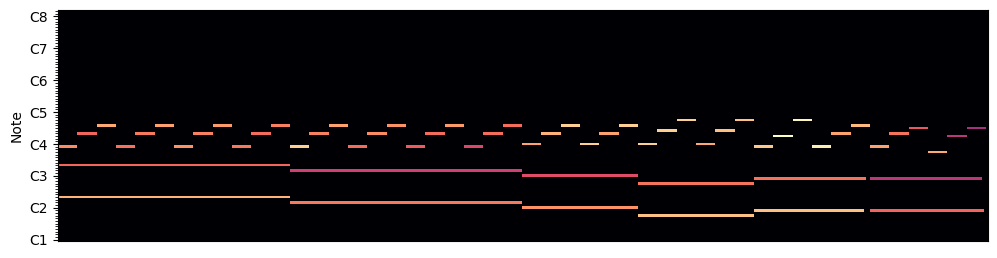

In [9]:
moonlight_midi = moonlight_midi.resample(tpq=30)
moonlight_pianoroll = moonlight_midi.pianoroll(
    modes=["frame"],
    pitch_range=[21, 108],
    encode_velocity=True
)
print("Pianoroll shape:", moonlight_pianoroll.shape)    # (modes, tracks, pitch, time)

plt.figure(figsize=(12, 3))
librosa.display.specshow(
    moonlight_pianoroll[0, 0], 
    y_axis='cqt_note'
)

ピアノロール形式の主な利点は、音響特徴量と時間軸が揃っているため、音と記号のタイミングが揃えやすいことです。

一方、一つの音符を表すのにいくつものマスを塗りつぶすのは冗長です。
実際に自動採譜モデルが出力するピアノロールには色々ノイズが入り込むので、音符の終始地点の特定が難しくなります。ピアノロールを楽譜データに変換するには、複雑なルールを決めなければなりません。

### 発展：Onsets and Frames

Magentaプロジェクトが提案したピアノ自動採譜手法「**Onsets and Frames**」[^onset18]は、上記の音符情報を表すピアノロールに加え、「ノート開始（onset）」位置を表すピアノロール行列を補助的な情報としてDNNに推定させました。自動採譜を「開始位置推定」と「ピアノロール推定」という2つのタスクに分割してマルチタスク学習を行うことで、音符推定精度が向上し、楽譜への変換も若干しやすくなります。


「**hFT-Transformer**」[^hft23]ではこれを更に発展させ、「ノート終止（offset）」と「ベロシティ」も補助情報に加え、4つのピアノロールを同時推定させています。

[^onset18]: Curtis Hawthorne et al., Onsets and frames: Dual-objective piano transcription, in Proceedings of the 19th  24th International Society for Music Information Retrieval Conference, 2018. URL: https://arxiv.org/abs/1710.11153

[^hft23]: Keisuke Toyama et al., Automatic Piano Transcription with Hierarchical Frequency-Time Transformer, in Proceedings of the 24th International Society for Music Information Retrieval Conference, 2023. URL: https://arxiv.org/abs/2307.04305

Pianoroll shape: (3, 1, 87, 481)


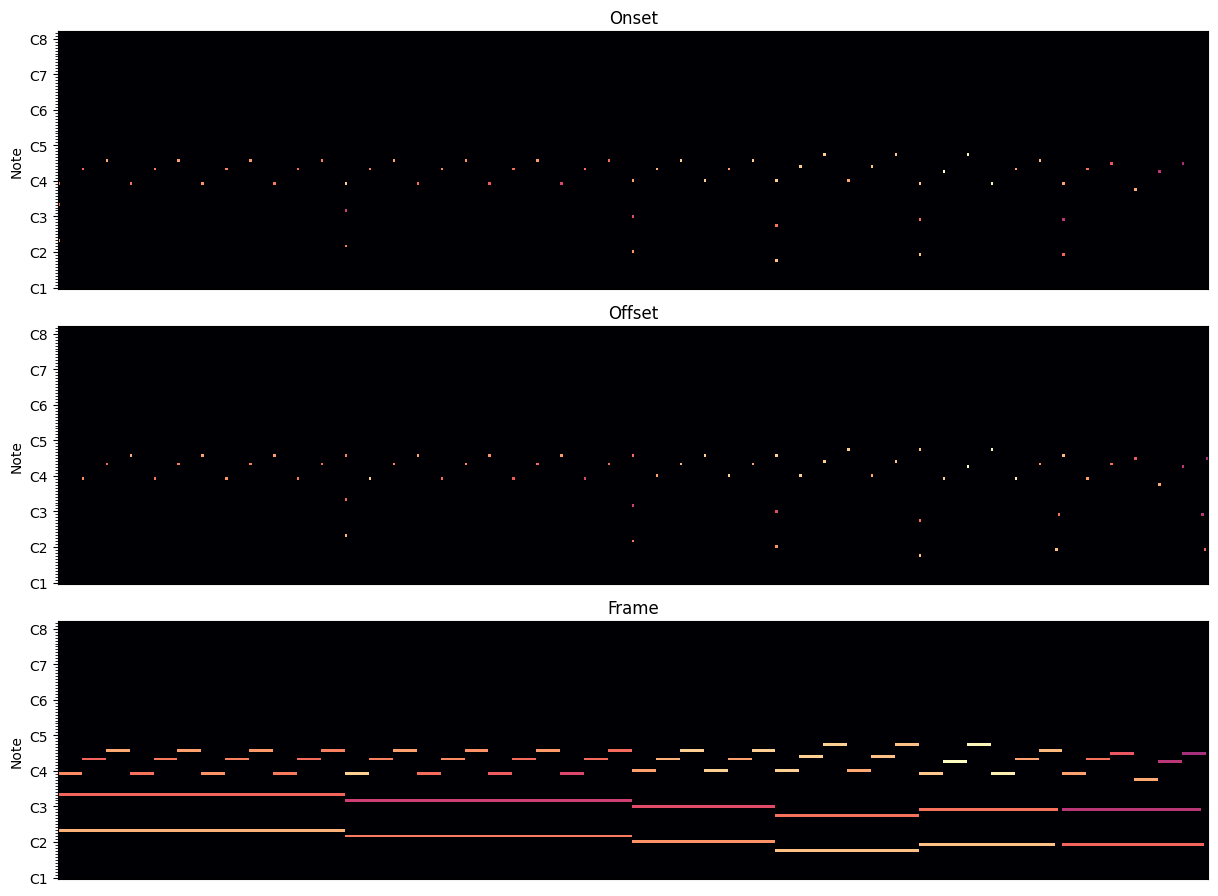

In [10]:
# modes引数を指定することで、オンセット、オフセットのピアノロールも取得できます。
moonlight_pianoroll_extended = moonlight_midi.pianoroll(
    modes=["onset", "offset", "frame"],
    pitch_range=[21, 108],
    encode_velocity=True
)

print("Pianoroll shape:", moonlight_pianoroll_extended.shape)    # (modes, tracks, pitch, time)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
librosa.display.specshow(moonlight_pianoroll_extended[0, 0],  y_axis='cqt_note')
plt.title("Onset")
plt.subplot(3, 1, 2)
librosa.display.specshow(moonlight_pianoroll_extended[1, 0], y_axis='cqt_note')
plt.title("Offset")
plt.subplot(3, 1, 3)
librosa.display.specshow(moonlight_pianoroll_extended[2, 0], y_axis='cqt_note')
plt.title("Frame")
plt.tight_layout()

## トークン列

自然言語処理研究から着想を得て、1次元の「離散トークン列」で楽譜情報を表し、何かしらの「言語モデル」でトークン列の生成過程をモデル化するアプローチです。

Magentaプロジェクトが提案したSeq2seq自動採譜手法[^CH21]では、楽譜のMIDIデータを「MIDI-likeトークン」で表し、メルスペクトログラムをトークン列に変換するEncoder-Decoderモデルを構築しました。MIDI-likeトークン列は、ノートオン・ノートオフなどのMIDIイベントをトークンで表現するフォーマットで、その名の通りMIDIフォーマットと似たような形式で音符情報を記述しています。

上記の手法のほかに、音源もEnCodecなどのNeural audio codecを使いトークン列に変換し、Decoder-onlyな言語モデルを使い音符トークンを推定する手法もあります[^au]。 

コントロールチェンジイベントをトークン列に加えれば、マルチトラックなMIDIデータも表現できます[^JG22]。



`MidiTok`ライブラリを使えば、MIDIデータを簡単にトークン列への変換できます。


[^CH21]: C. Hawthorne et al., Sequence-to-sequence piano transcription with transformers, in Proceedings of the 22th International Society for Music Information Retrieval (ISMIR), 2021. URL: https://archives.ismir.net/ismir2021/paper/000030.pdf

[^JG22]: Josh Gardner et al., MT3: Multi-Task Multitrack Music Transcription, in Proceedings of ICLR, 2022,URL: https://openreview.net/pdf?id=iMSjopcOn0p

[^au]: Audio Understanding with Large Language Models: https://github.com/qiuqiangkong/audio_understanding

In [11]:
from miditok import MIDILike, TokenizerConfig

config = TokenizerConfig(
    num_velocities = 16,
)
tokenizer = MIDILike(config)

tokens = tokenizer(moonlight_midi)
print("Tokens:", tokens)


Tokens: [TokSequence(tokens=['NoteOn_37', 'Velocity_55', 'NoteOn_49', 'Velocity_39', 'NoteOn_56', 'Velocity_47', 'TimeShift_0.3.8', 'NoteOff_56', 'NoteOn_61', 'Velocity_39', 'TimeShift_0.2.8', 'NoteOn_64', 'Velocity_47', 'TimeShift_0.1.8', 'NoteOff_61', 'TimeShift_0.2.8', 'NoteOff_64', 'NoteOn_56', 'Velocity_47', 'TimeShift_0.3.8', 'NoteOff_56', 'NoteOn_61', 'Velocity_47', 'TimeShift_0.2.8', 'NoteOn_64', 'Velocity_47', 'TimeShift_0.1.8', 'NoteOff_61', 'TimeShift_0.2.8', 'NoteOff_64', 'NoteOn_56', 'Velocity_47', 'TimeShift_0.3.8', 'NoteOff_56', 'NoteOn_61', 'Velocity_47', 'TimeShift_0.2.8', 'NoteOn_64', 'Velocity_47', 'TimeShift_0.1.8', 'NoteOff_61', 'TimeShift_0.2.8', 'NoteOff_64', 'NoteOn_56', 'Velocity_47', 'TimeShift_0.3.8', 'NoteOff_56', 'NoteOn_61', 'Velocity_39', 'TimeShift_0.2.8', 'NoteOn_64', 'Velocity_47', 'TimeShift_0.1.8', 'NoteOff_61', 'TimeShift_0.2.8', 'NoteOff_37', 'NoteOff_49', 'NoteOff_64', 'NoteOn_35', 'Velocity_47', 'NoteOn_47', 'Velocity_31', 'NoteOn_56', 'Velocity_

ピアノロール形式のように音符を細切りにしないコンパクトな表現なので、比較的単純なルールで楽譜に変換できます。一方、自己回帰型言語モデルのようにトークン列を逐次的に推論することになるので、推論は遅めです。

また、トークン列の構造が音響特徴量と大きく異なるため、自動採譜モデルの学習も比較的困難です。

## セミマルコフCRF

セミマルコフCRF(Semi-Markov Conditional Random Fields)に基づく自動採譜手法[^yan2021]では、$T\times T\times N$（$T=$フレーム数、$N=$音高数）の行列を使い音符集合を表現します。

行列の$(i, j, n)$位置は、「時刻$i$で始まり、時刻$j$で終わるノートイベント$n$」の有無を表します。この行列をセミマルコフCRFの「**スコア行列**」と見なすことで、自動採譜モデルを定式化します。

![score](assets/semicrf_score_matrix.png)

フレーム数$T$の2乗に従って増大する巨大な行列ですが、その中で表される音符は、
+ $i<j$でなければならない
+ 同じ音高の音符同士は重ならない

という縛りがあるので、実際はほとんどの値が無効な疎行列です。最近の研究[^yan2024]では、スコア行列を $T\times D\times N$、$D\times T\times N$、$T\times N$ の3つの行列に分解することで（$D\ll N$）、よりコンパクトな形式で表せることが示されました。




[^yan2021]: Yujia Yan et al., Skipping the Frame-Level: Event-Based Piano Transcription With Neural Semi-{CRF}s, in Proceedings of Advances in Neural Information Processing Systems (NIPS), 2021. URL: https://proceedings.neurips.cc/paper/2021/hash/ac53fab47b547a0d47b77e424cf119ba-Abstract.html

[^yan2024]: Yujia Yan et al., Scoring Time Intervals Using Non-Hierarchical Transformer for Automatic Piano Transcription, in Proceedings of the International Society for Music Information Retrieval Conference (ISMIR), 2024. URL: https://arxiv.org/abs/2404.09466



In [12]:
import torch

linear_head = torch.nn.Linear(128, 128 + 128 + 1)

h = torch.randn(1, 88, 1024, 128)   # (batch, N, T, D): DNNの出力
y = linear_head(h)
q, k, b = torch.split(y, [128, 128, 1], dim=-1)
b = b.squeeze(-1)

print("q:", q.shape)
print("k:", k.shape)
print("b:", b.shape)    

score_matrix = q @ k.transpose(-1, -2) + torch.diag_embed(b)
print("Score matrix:", score_matrix.shape)    # (batch, N, T, T)：再構成されたスコア行列

q: torch.Size([1, 88, 1024, 128])
k: torch.Size([1, 88, 1024, 128])
b: torch.Size([1, 88, 1024])
Score matrix: torch.Size([1, 88, 1024, 1024])
